In [ ]:
!gdown --id 1RLFYFinS2WyGGqJGIMO0USBMPfmqQhwr 

Downloading...
From: https://drive.google.com/uc?id=1RLFYFinS2WyGGqJGIMO0USBMPfmqQhwr
To: /content/CelldataVal.zip
15.0MB [00:00, 29.2MB/s]


In [ ]:
!unzip CelldataVal   # unzip downloaded file

Archive:  CelldataVal.zip
replace CelldataVal/test/0.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace CelldataVal/test/1.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!rm CelldataVal.zip    # delete zip file to release memory

In [ ]:
#installation of libraries, need to be on CPU, and restart environment before continue
!pip install -U numpy
!pip install scipy==1.6.3
!pip install torch==1.4.0
!pip install torchvision==0.5.0
!pip install git+https://github.com/bruel-gabrielsson/TopologyLayer.git #to install lybrary for Topology loss
!pip install --upgrade Cython
!pip install --upgrade Ripser
!pip install --upgrade persim
!pip install --upgrade diagram2vec

Requirement already up-to-date: numpy in /usr/local/lib/python3.7/dist-packages (1.20.3)
  Cloning https://github.com/bruel-gabrielsson/TopologyLayer.git to /tmp/pip-req-build-7kyf36jc
  Running command git clone -q https://github.com/bruel-gabrielsson/TopologyLayer.git /tmp/pip-req-build-7kyf36jc
Requirement already up-to-date: Cython in /usr/local/lib/python3.7/dist-packages (0.29.23)
Requirement already up-to-date: Ripser in /usr/local/lib/python3.7/dist-packages (0.6.0)
Requirement already up-to-date: persim in /usr/local/lib/python3.7/dist-packages (0.3.1)
Requirement already up-to-date: diagram2vec in /usr/local/lib/python3.7/dist-packages (0.0.2)


In [ ]:
!mkdir model

mkdir: cannot create directory ‘model’: File exists


## DATASET

I deleted resize as for topology loss it is hard to compute on image with a lot of details. Also I used image_size = 64 because of the same reason.

In [ ]:
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from torchvision.transforms import ToTensor
import os
from PIL import Image
import numpy as np
import torch
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
# As our dataset is small we added augmentation
class CellData(Dataset):
    """
    Labels: 1,0
    """
    def __init__(
        self,
        data_path: str,
        phase: str,
        augment: bool,
        img_size: int,):
        self.num_classes = 2
        self.data_path = data_path
        self.phase = phase
        self.augment = augment
        self.img_size = img_size
        
        self.items = [filename.split('.')[0] for filename in os.listdir(f'{data_path}/{self.phase}/image')]
        
        # TODO: implement augmentations 
        if augment:
            # TODO:
            # Random resize
            # Random crop (within image borders, output size = img_size)
            # Random rotation
            # Random horizontal and vertical Flip
            # Random color augmentation
            self.transform = A.Compose([
                #A.Resize(300, 300),
                A.RandomCrop(width=self.img_size, height=self.img_size),
                A.RandomRotate90(p=1),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomBrightnessContrast(),
                A.RandomGamma(p=1),])

        else:
        	# TODO: random crop to img_size
            self.transform = A.RandomCrop(img_size,img_size)
        
        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        image = np.asarray(Image.open(f'{self.data_path}/{self.phase}/image/{self.items[index]}.tif'))
        mask = np.asarray(Image.open(f'{self.data_path}/{self.phase}/mask/{self.items[index]}.tif'))
        image = image.astype(np.float32)
        image = np.expand_dims(image, -1)
        image = image / 255
        mask = mask.astype(np.float32)
        mask = mask / 255
        if self.phase == 'train':
          # TODO: apply transform to both image and mask 
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        else:
            transformed = A.RandomCrop(width=self.img_size, height=self.img_size)(image=image, mask=mask)            
            image = transformed['image']
            mask = transformed['mask']
            
        image = self.to_tensor(image.copy())
        mask = torch.from_numpy(mask.copy()).long()
        
        if self.phase == 'train':
            assert isinstance(image, torch.FloatTensor) and image.shape == (1, self.img_size, self.img_size)
            assert isinstance(mask, torch.LongTensor) and mask.shape == (self.img_size, self.img_size)

        return image, mask


# MODEL

U-Net architecture.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up_scale = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

    def forward(self, x1, x2):
        x2 = self.up_scale(x2)

        diffY = x1.size()[2] - x2.size()[2]
        diffX = x1.size()[3] - x2.size()[3]

        x2 = F.pad(x2, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return x


class down_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down_layer, self).__init__()
        self.pool = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(self.pool(x))
        return x


class up_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_layer, self).__init__()
        self.up = up(in_ch, out_ch)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        a = self.up(x1, x2)
        x = self.conv(a)
        return x


class UNet(nn.Module):
    def __init__(self, dimensions=2):
        super(UNet, self).__init__()
        self.conv1 = double_conv(1, 64)
        self.down1 = down_layer(64, 128)
        self.down2 = down_layer(128, 256)
        self.down3 = down_layer(256, 512)
        self.down4 = down_layer(512, 1024)
        self.up1 = up_layer(1024, 512)
        self.up2 = up_layer(512, 256)
        self.up3 = up_layer(256, 128)
        self.up4 = up_layer(128, 64)
        self.last_conv = nn.Conv2d(64, dimensions, 1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x1_up = self.up1(x4, x5)
        x2_up = self.up2(x3, x1_up)
        x3_up = self.up3(x2, x2_up)
        x4_up = self.up4(x1, x3_up)
        output = self.last_conv(x4_up)
        return torch.sigmoid(output)

# TRAIN

We trained U-Net on small patches from our data. And save model on epoch when it shows best loss on validation.

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import random
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings
warnings.filterwarnings( 'ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(epoch_number = 5, data_path = 'CelldataVal', pretrained_path = 'model/unet-cell.pt' ):
    ############################################################
    train_dataset = CellData(data_path, 'train', True, 64)
    trainloader = DataLoader(train_dataset, num_workers=4, batch_size=1, shuffle=True)
    ###############################################################
    test_dataset = CellData(data_path, 'val', True, 64)
    valloader = DataLoader(test_dataset, num_workers=4, batch_size=1, shuffle=True)
    ###############################################################
    best_loss= float('inf')
    model = UNet(dimensions=2).to(device)
    #if os.path.isfile(pretrained_path):
    #    model.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cuda')))
    #optimizer = optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.98)
    optimizer = optim.Adam(model.parameters(), lr=0.00003)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epoch_number):
        train_loss_ = []
        val_loss = []
        train_acc = []
        val_acc = []
        train_loss, val_loss = 0,0
        # Traning Loop
        model.train()
        for input, target in trainloader:
            input, target = input.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, target)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        model.eval()
        for input, target in valloader:
            input, target = input.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, target)
            val_loss += loss.item()
        if  val_loss/len(valloader) < best_loss:  # save best model
            best_loss = val_loss/len(valloader)
            torch.save(model.state_dict(), pretrained_path)
        train_loss_.append(train_loss/len(trainloader))
        if epoch % 5 == 0:
            print(f'Epoch: {epoch} \t Train Loss: {train_loss/len(trainloader)} \t Val Loss: {val_loss/len(valloader)}')
            
            
    return train_loss

In [ ]:
# True - for training from begining, False - to download saved weights.
do_train = False

In [ ]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
if do_train == True:
  train_loss = train(100)
else:
  !gdown --id 16UwHEf7XfiXz_IbTNwSFY4GonjslDAjA
  !mv '/content/unet-cell.pt' '/content/model/'

Downloading...
From: https://drive.google.com/uc?id=16UwHEf7XfiXz_IbTNwSFY4GonjslDAjA
To: /content/unet-cell.pt
124MB [00:01, 106MB/s]


# Metrics

In [ ]:
import matplotlib.image as mpimg
import os
from ripser import lower_star_img
import matplotlib.pyplot as plt
import persim
# to count betti number error, we used ripser library
def betti_number(img_true, pred):
    diags_pred = lower_star_img(pred)[:-1]
    diags = lower_star_img(img_true)[:-1]
    return len(diags_pred) - len(diags)

In [ ]:
def get_metrics(img_predicted, img_true):
    '''
    binary segmented feature maps
    '''
    tp = float(np.logical_and(img_true, img_predicted).sum())
    fp = float(np.logical_and(1 - img_true, img_predicted).sum())
    tn = float(np.logical_and(1 - img_true, 1 - img_predicted).sum())
    fn = float(np.logical_and(img_true,  1 - img_predicted).sum())

    accuracy = (tp + tn) / (tp + fp + tn + fn)
    completeness = tp / (tp + fn)
    dice = 2 * tp / (2 * tp + fp + fn)
    correctness = tp / (tp + fp)
    quality = tp / (tp + fp + fn)
    betti_dif = 0
    for i in np.random.uniform(0,383,10):
        i = int(i)
        betti_dif += abs(betti_number(img_true[i:i+64,i:i+64], img_predicted[i:i+64,i:i+64]))
        
   
    return accuracy, completeness, correctness, quality,  dice , betti_dif/10

# PREDICT

Function predict uses saved weights of model to predict mask on full data from validation dataset. Also, it saves predictions and count metrics.

In [ ]:
!mkdir results
!mkdir results/without_topo

In [ ]:
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
def predict(data_folder = 'CelldataVal', pretrained_path = 'model/unet-cell.pt', model_type = 'without_topo'):
    test_dataset = CellData(data_folder, 'val', True, 512)
    valloader = DataLoader(test_dataset, num_workers=2, batch_size=1, shuffle=True)
    model = UNet()
    checkpoint = torch.load(pretrained_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint)
    model.eval()
    acc, completenes, correctness,quality, dice, betti = 0.0, 0.0, 0.0, 0.0,0.0, 0.0
    for ii, (input, target) in enumerate(valloader):
        output = model(input).permute(0, 2, 3, 1).squeeze().detach().numpy()
        input_array = input.squeeze().detach().numpy()
        target_array = target.squeeze().detach().numpy()
        output_array = output.argmax(2)
        tacc, tcmp, tcrr, tql, tdic, bet = get_metrics(output_array, target_array) 
        acc+=tacc
        completenes +=tcmp 
        correctness +=tcrr
        quality += tql 
        dice+=tdic
        betti += bet
        # save the images, preds, and target 
        plt.imsave('results/'+model_type+'/input_img{}.png'.format(ii),input_array, cmap = 'gray')
        plt.imsave('results/'+model_type+'/pred_img{}.png'.format(ii),output_array, cmap = 'gray')
        plt.imsave('results/'+model_type+'/target_img{}.png'.format(ii),target_array, cmap = 'gray')

    return acc/len(valloader), completenes/len(valloader), correctness/len(valloader), quality/len(valloader), dice/len(valloader), betti/len(valloader)

In [ ]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

ac, cp, cr, ql, d,b = predict()
ac,cp,cr,ql,d,b

(0.8997917175292969,
 0.9746939287762532,
 0.9072739702358594,
 0.8862053376998744,
 0.939648509073451,
 1.1600000000000001)

# Topological Loss based

To compute topological loss we used topologylayer library, in this library by using of PyTorch library and C++ the differentiable persistence diagrams were implemented.



In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import numpy.fft as ft
import os

%matplotlib inline

import torch
import torchvision.datasets as datasets
import torchsummary
from torch import nn, optim
from torch.nn import functional as F

from topologylayer.nn import LevelSetLayer2D, TopKBarcodeLengths
device = torch.device("cpu")

In [ ]:
dgminfo = LevelSetLayer2D(size=(64,64), sublevel=False, maxdim=1)
l2_loss = nn.MSELoss()
L_sqdiff_weight = 30 # hyper-parameter
max_k = 30 # only consider this many bars - most will be 0-length anyway


We added topological loss to CrossEntropyLoss.

In [ ]:
class TopLoss(nn.Module):
    def __init__(self, size):
        super(TopLoss, self).__init__()
        self.pdfn = LevelSetLayer2D(size=size,  sublevel=False)

    def forward(self, pred, true):
        loss_ = 0
        for i in range(pred.shape[0]):
          dgm = self.pdfn(pred[i,1,:,:])
          dgm_true = self.pdfn(true.float()[i,:,:])
          dgm_b1, indices1 = dgm[0][0][1:,0].sort(descending=True)
          dgm_d1 = dgm[0][0][1:,1][indices1]
          dgm_true_b1, indices_true1 = dgm_true[0][0][1:,0].sort(descending=True)
          dgm_true_d1 = dgm_true[0][0][1:,1][indices_true1]
          dgm_b2, indices2 = dgm[0][1][1:,0].sort(descending=True)
          dgm_d2 = dgm[0][1][1:,1][indices2]
          dgm_true_b2, indices_true2 = dgm_true[0][1][1:,0].sort(descending=True)
          dgm_true_d2 = dgm_true[0][1][1:,1][indices_true2]
          loss_ += ((dgm_b1-dgm_true_b1)**2).sum() + ((dgm_d1-dgm_true_d1)**2).sum() \
          + ((dgm_b2-dgm_true_b2)**2).sum() + ((dgm_d2-dgm_true_d2)**2).sum()
        return loss_



In [ ]:
from ripser import lower_star_img
import persim

def train_topo(epoch_number = 5, data_path = 'CelldataVal', pretrained_path = 'model/unet-cell_topo.pt' ):
    ############################################################
    train_dataset = CellData(data_path, 'train', True, 64)
    trainloader = DataLoader(train_dataset, num_workers=4, batch_size=1, shuffle=True)
    ###############################################################
    test_dataset = CellData(data_path, 'val', True, 64)
    valloader = DataLoader(test_dataset, num_workers=4, batch_size=1, shuffle=True)
    ###############################################################
    best_loss= float('inf')
    model = UNet(dimensions=2).to(device)
    #if os.path.isfile(pretrained_path):
        #model.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cuda')))
    #optimizer = optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.98)
    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=2.3e-9)
    criterion = nn.CrossEntropyLoss()
    topoloss = TopLoss((64,64))
    for epoch in range(epoch_number):
        train_loss_ = []
        val_loss = []
        train_acc = []
        val_acc = []
        train_loss, val_loss = 0, 0
        # Traning Loop
        model.train()
        for inputs, target in trainloader:
            inputs, target = inputs.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            
            T = topoloss(output,target)
            L_sqdiff = criterion(output, target)
            loss = L_sqdiff + T/6000
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        model.eval()
        for input, target in valloader:
            input, target = input.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(input)
            T =  topoloss(output,target)
            L_sqdiff = criterion(output, target)
            loss = L_sqdiff + T/6000
            val_loss += loss.item()
        if  val_loss/len(valloader) < best_loss:  # save best model
            best_loss = val_loss/len(valloader)
            torch.save(model.state_dict(), pretrained_path)
        train_loss_.append(train_loss/len(trainloader))
        if  epoch % 5 == 0:
            print(f'Epoch: {epoch} \t Train Loss: {round(train_loss/len(trainloader),3)} \t T: {round(T.item()/6000,3)} \t BCE: {round(L_sqdiff.item(),3)} \t Val Loss: {round(val_loss/len(valloader),3)}')
            diags_pred = lower_star_img(output[0,1,:,:].detach().numpy())[:-1]
            fig = plt.figure(figsize=(8,4))
            plt.suptitle("Persistent diagrams")
            
            plt.subplot(111)
            plt.title("Pred")
            plt.grid(linestyle="dotted")
            persim.plot_diagrams(diags_pred)

            plt.show()

            
    return train_loss, val_loss, train_acc, val_acc

Epoch: 0 	 Train Loss: 1.411 	 T: 0.935 	 BCE: 0.687 	 Val Loss: 1.679


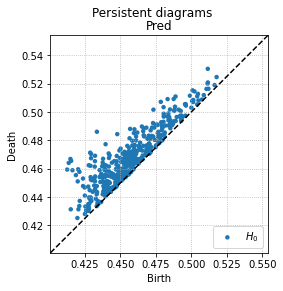

Epoch: 5 	 Train Loss: 1.15 	 T: 0.326 	 BCE: 0.565 	 Val Loss: 0.927


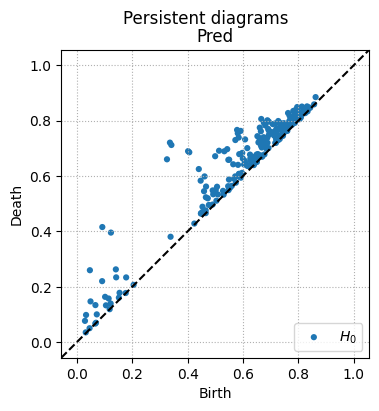

Epoch: 10 	 Train Loss: 1.048 	 T: 2.38 	 BCE: 0.781 	 Val Loss: 1.749


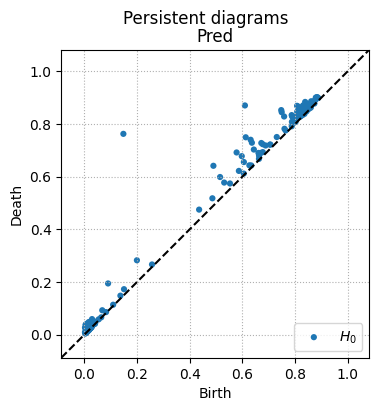

Epoch: 15 	 Train Loss: 0.946 	 T: 0.212 	 BCE: 0.512 	 Val Loss: 0.86


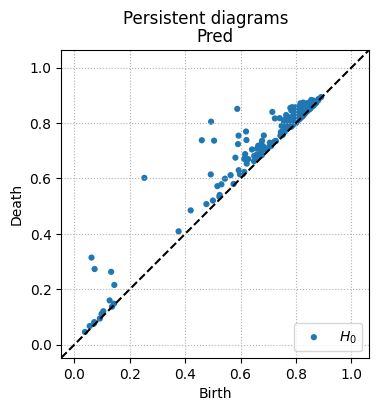

Epoch: 20 	 Train Loss: 0.928 	 T: 0.368 	 BCE: 0.547 	 Val Loss: 0.808


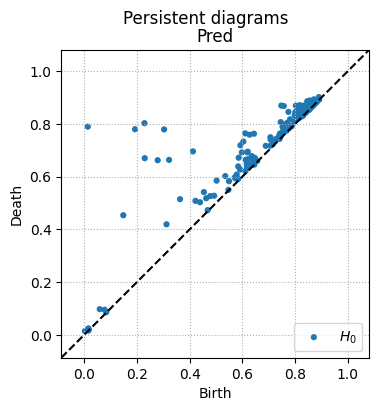

Epoch: 25 	 Train Loss: 0.915 	 T: 0.177 	 BCE: 0.516 	 Val Loss: 0.837


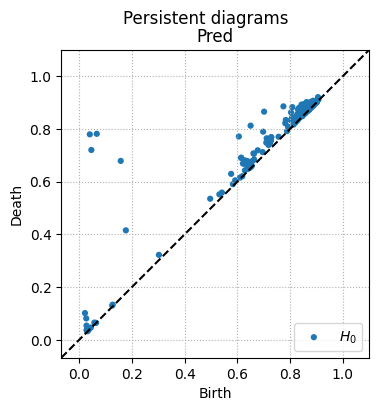

Epoch: 30 	 Train Loss: 1.011 	 T: 0.205 	 BCE: 0.514 	 Val Loss: 0.796


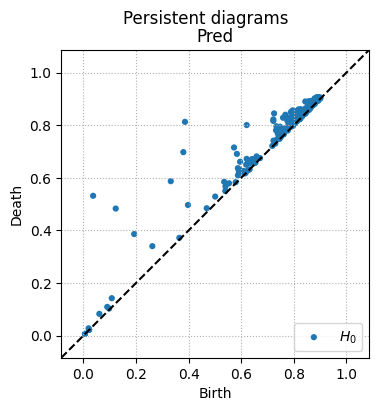

Epoch: 35 	 Train Loss: 0.874 	 T: 0.203 	 BCE: 0.534 	 Val Loss: 0.731


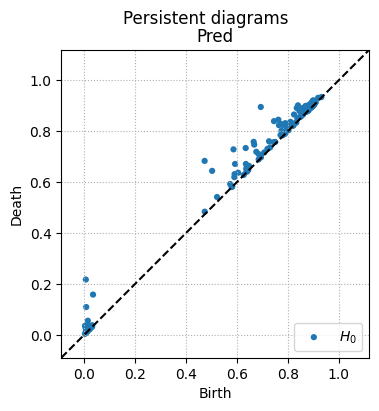

Epoch: 40 	 Train Loss: 0.89 	 T: 0.16 	 BCE: 0.492 	 Val Loss: 0.703


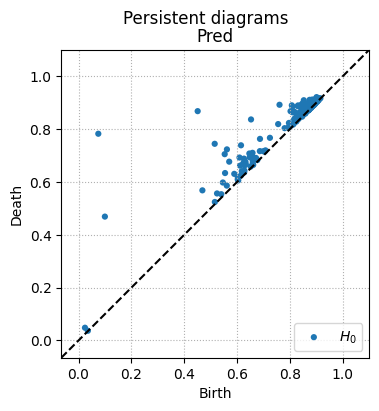

Epoch: 45 	 Train Loss: 0.886 	 T: 0.214 	 BCE: 0.51 	 Val Loss: 0.68


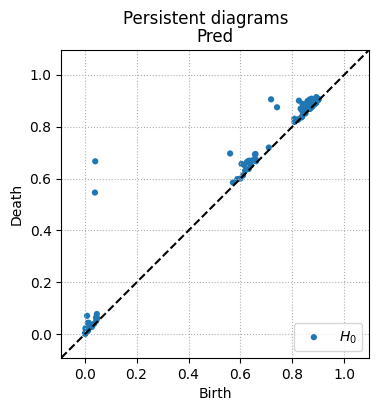

Epoch: 50 	 Train Loss: 0.849 	 T: 0.191 	 BCE: 0.539 	 Val Loss: 0.817


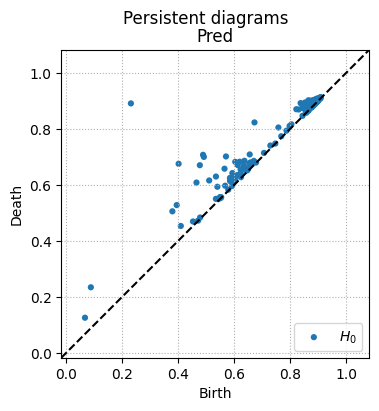

Epoch: 55 	 Train Loss: 0.814 	 T: 0.091 	 BCE: 0.448 	 Val Loss: 0.671


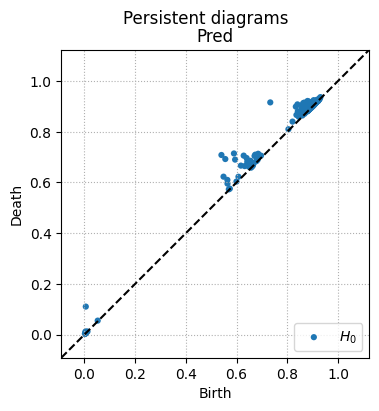

Epoch: 60 	 Train Loss: 0.856 	 T: 0.111 	 BCE: 0.463 	 Val Loss: 0.651


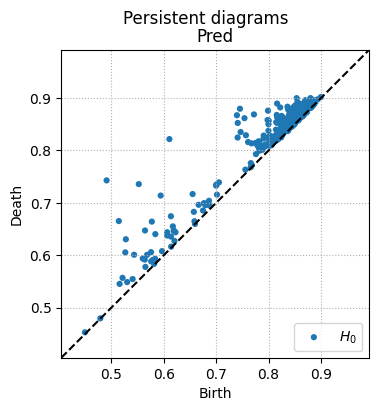

Epoch: 65 	 Train Loss: 0.748 	 T: 0.118 	 BCE: 0.463 	 Val Loss: 0.62


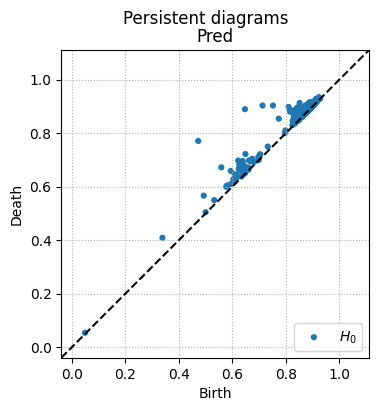

Epoch: 70 	 Train Loss: 0.756 	 T: 0.175 	 BCE: 0.485 	 Val Loss: 0.669


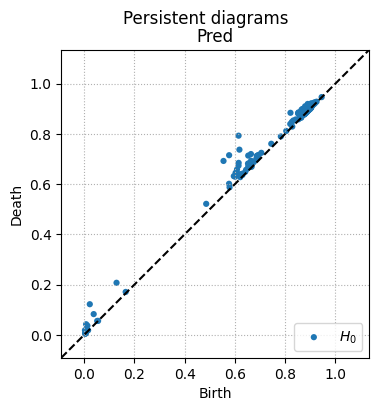

Epoch: 75 	 Train Loss: 0.765 	 T: 0.291 	 BCE: 0.514 	 Val Loss: 0.675


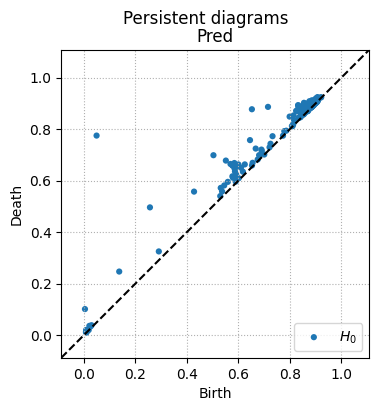

Epoch: 80 	 Train Loss: 0.826 	 T: 0.135 	 BCE: 0.455 	 Val Loss: 0.663


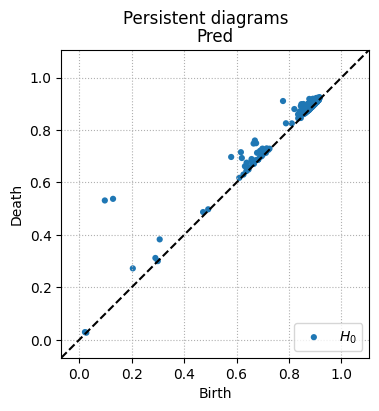

Epoch: 85 	 Train Loss: 0.737 	 T: 0.194 	 BCE: 0.481 	 Val Loss: 0.619


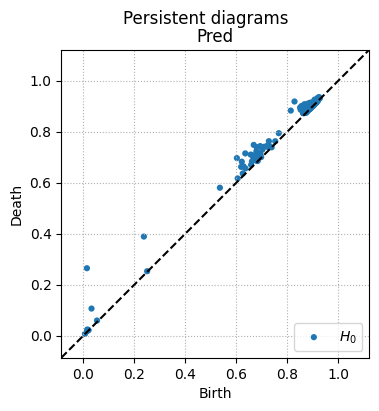

Epoch: 90 	 Train Loss: 0.706 	 T: 0.155 	 BCE: 0.495 	 Val Loss: 0.677


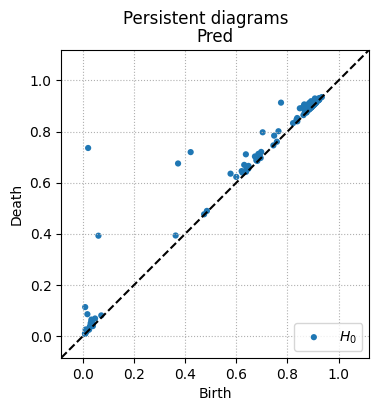

Epoch: 95 	 Train Loss: 0.848 	 T: 0.308 	 BCE: 0.542 	 Val Loss: 0.669


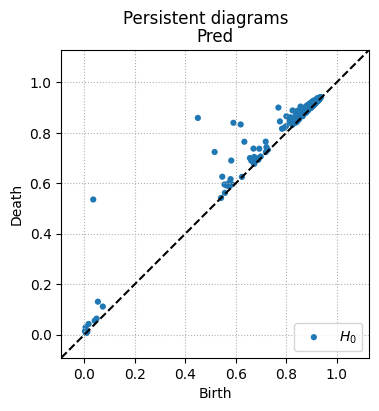

In [ ]:
#this cell for demonstrating different persistent diagrams and training process
#random.seed(1)
#np.random.seed(1)
#torch.manual_seed(1)
#_,_,_,_=train_topo(100)

In [ ]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
if do_train == True:
  train_loss = train_topo(100)
else:
  !gdown --id 1gkhblZIEHXvDvizphTM3gZGQJrsidhv2
  !mv '/content/unet-cell_topo.pt' '/content/model/'

Downloading...
From: https://drive.google.com/uc?id=1gkhblZIEHXvDvizphTM3gZGQJrsidhv2
To: /content/unet-cell_topo.pt
124MB [00:01, 97.7MB/s]


In [ ]:
!mkdir results/with_topo

mkdir: cannot create directory ‘results/with_topo’: File exists


In [ ]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

ac_t, cp_t, cr_t, ql_t, d_t, b_t = predict(pretrained_path = 'model/unet-cell_topo.pt',model_type = 'with_topo')
ac_t,cp_t,cr_t,ql_t,d_t, b_t

(0.910064697265625,
 0.9512505753500022,
 0.9376763888474224,
 0.894404130660682,
 0.9442567886227428,
 1.02)

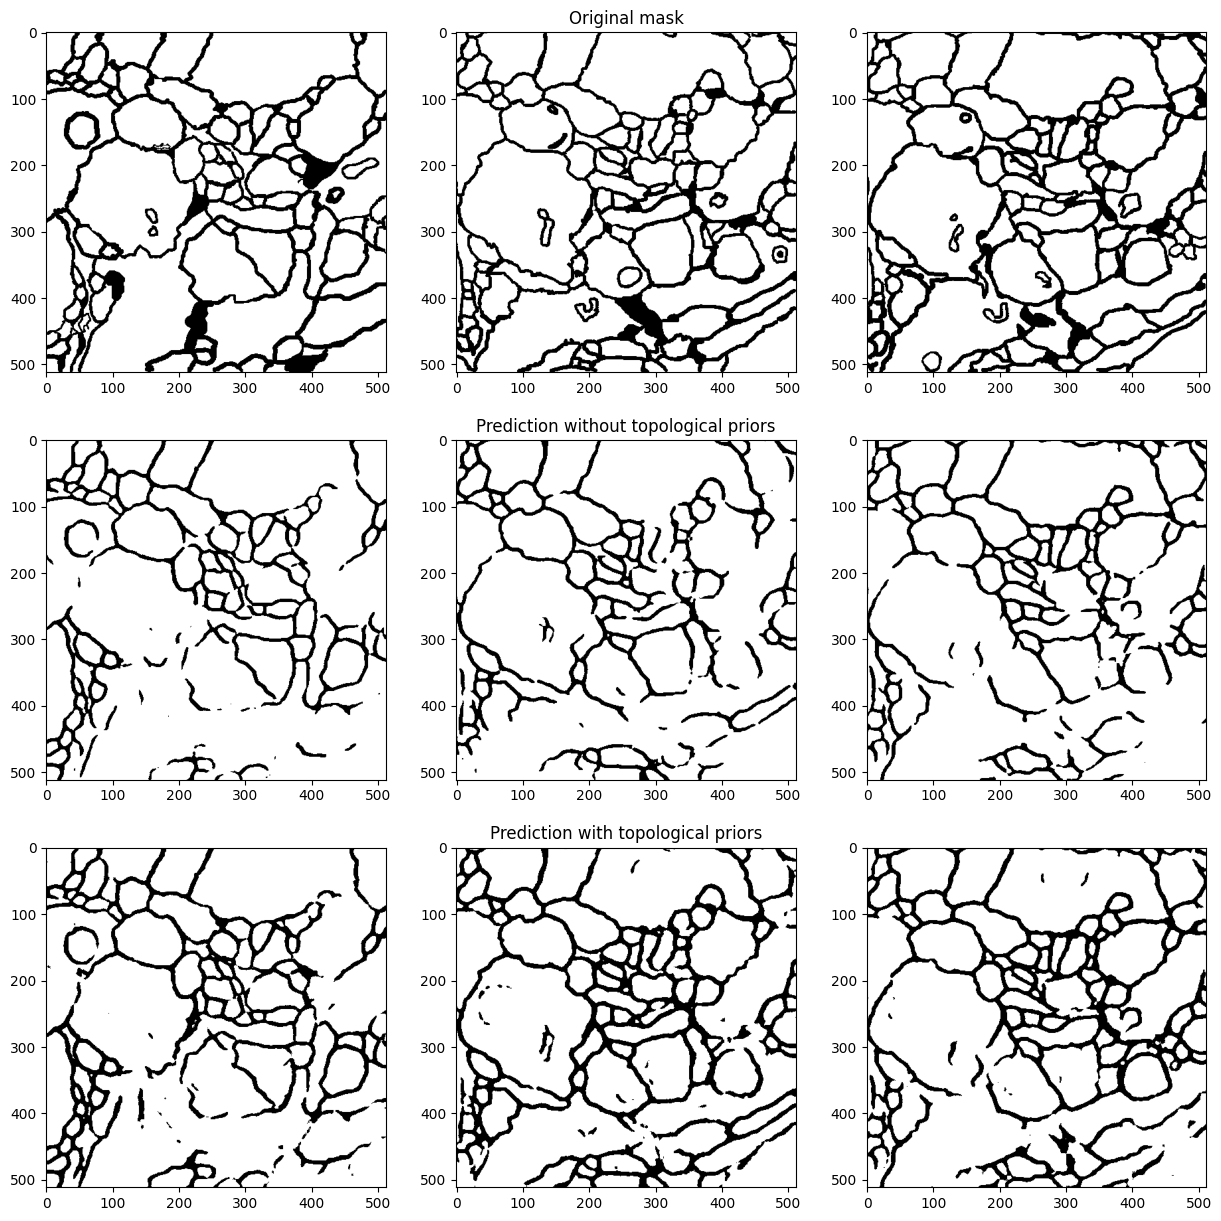

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(15,15))
ax[0,0].imshow(np.asarray(Image.open(f'results/without_topo/target_img1.png')))
ax[0,1].imshow(np.asarray(Image.open(f'results/without_topo/target_img2.png')))
ax[0,1].set_title('Original mask')
ax[0,2].imshow(np.asarray(Image.open(f'results/without_topo/target_img4.png')))
ax[1,0].imshow(np.asarray(Image.open(f'results/without_topo/pred_img1.png')))
ax[1,1].imshow(np.asarray(Image.open(f'results/without_topo/pred_img2.png')))
ax[1,1].set_title('Prediction without topological priors')
ax[1,2].imshow(np.asarray(Image.open(f'results/without_topo/pred_img4.png')))
ax[2,0].imshow(np.asarray(Image.open(f'results/with_topo/pred_img1.png')))
ax[2,1].imshow(np.asarray(Image.open(f'results/with_topo/pred_img2.png')))
ax[2,1].set_title('Prediction with topological priors')
ax[2,2].imshow(np.asarray(Image.open(f'results/with_topo/pred_img4.png')))

## Adding topological priors to dataset

In [ ]:
import numpy as np # handling arrays and general math
from scipy import sparse # working with sparse matrices
from ripser import lower_star_img # computing topological persistence of images
from scipy.sparse.csgraph import connected_components # compute connected components from sparse adjacency matrix
import cv2 # image processing library
import random # setting seeds
from scipy import ndimage # image smoothening
import PIL # imaging library
from scipy.ndimage.morphology import distance_transform_edt # compute closest background pixel
from skimage.measure import find_contours # find iso-valued contours in an image


def img_to_sparseDM(img):
    """
    Compute a sparse distance matrix from the pixel entries of a single channel image for persistent homology
    
    Parameters
    ----------
    img: ndarray (M, N)
        An array of single channel image data
        Infinite entries correspond to empty pixels
        
    Returns
    -------
    sparseDM: scipy.sparse (M * N, M * N)
        A sparse distance matrix representation of img
    """
    m, n = img.shape

    idxs = np.arange(m * n).reshape((m, n))

    I = idxs.flatten()
    J = idxs.flatten()
    
    # Make sure non-finite pixel entries get added at the end of the filtration
    img[img==-np.inf] = np.inf
    V = img.flatten()

    # Connect 8 spatial neighbors
    tidxs = np.ones((m + 2, n + 2), dtype=np.int64) * np.nan
    tidxs[1:-1, 1:-1] = idxs

    tD = np.ones_like(tidxs) * np.nan
    tD[1:-1, 1:-1] = img

    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:

            if di == 0 and dj == 0:
                continue

            thisJ = np.roll(np.roll(tidxs, di, axis=0), dj, axis=1)
            thisD = np.roll(np.roll(tD, di, axis=0), dj, axis=1)
            thisD = np.maximum(thisD, tD)

            # Deal with boundaries
            boundary = ~np.isnan(thisD)
            thisI = tidxs[boundary]
            thisJ = thisJ[boundary]
            thisD = thisD[boundary]

            I = np.concatenate((I, thisI.flatten()))
            J = np.concatenate((J, thisJ.flatten()))
            V = np.concatenate((V, thisD.flatten()))
            
    return sparse.coo_matrix((V, (I, J)), shape=(idxs.size, idxs.size))


def connected_components_img(img):
    """
    Identify the connected components of an image
    
    Parameters
    ----------
    img: ndarray (M, N)
        An array of single channel image data
        Infinite entries correspond to empty pixels
        
    Returns
    -------
    img: ndarray (M, N)
        An array of single channel image data where each pixel value equals its modified lifespan
    """
    
    m, n = img.shape
    
    component = connected_components(img_to_sparseDM(img), directed=False)[1].reshape((m, n))
            
    return component


def smoothen(img, window_size):
    
    return(ndimage.uniform_filter(img.astype("float"), size=window_size))


def add_border(img, border_width):
    
    border_value = np.min(img) - 1 # make sure the pixels near the border reach te minimal value
    
    img[0:border_width,:] = border_value
    img[(img.shape[0] - border_width):img.shape[0],:] = border_value
    img[:,0:border_width] = border_value
    img[:,(img.shape[1] - border_width):img.shape[1]] = border_value

    return(img)


def lifetimes_from_dgm(dgm, tau=False):
    """
    Rotate a persistence diagram by 45 degrees, to indicate lifetimes by the y-coordinate
    
    Parameters
    ----------
    dgm: ndarray (K, 2)
        The persistence diagram to rotate
    tau: boolean
        Whether to return a threshold for indentifying connected components
        
    Returns
    -------
    dgm_lifetimes: ndarray (K, 2)
        The rotated diagram
        
    tau: float
        A threshold for identifying connected components 
        as those with finite oordinate above tau in the rotated diagram
    """ 
    
    dgm_lifetimes = np.vstack([dgm[:,0], dgm[:,1] - dgm[:,0]]).T
        
    if(tau):
        dgm_for_tau = np.delete(dgm_lifetimes.copy(), np.where(dgm_lifetimes[:,1] == np.inf)[0], axis=0)
        sorted_points = dgm_for_tau[:,1]
        sorted_points[::-1].sort()
        dist_to_next = np.delete(sorted_points, len(sorted_points) - 1) - np.delete(sorted_points, 0)
        most_distant_to_next = np.argmax(dist_to_next)
        tau = (sorted_points[most_distant_to_next] + sorted_points[most_distant_to_next + 1]) / 2
        
        return dgm_lifetimes, tau
    
    return dgm_lifetimes


def contour_segmentation(img, isovalue=None, return_contours=False):
    
    if isovalue is None:
        isovalue = np.mean(img)
    
    contours = find_contours(img, isovalue)
    img_segmented = np.zeros_like(img)
    for contour in contours:
        contour = np.int32(contour[:,range(1, -1, -1)]).reshape([1, contour.shape[0], contour.shape[1]])
        cv2.fillPoly(img_segmented, contour, 1)
        
    if return_contours:
        return img_segmented, contours
    
    return img_segmented


def topological_process_img(img, dgm=None, tau=None, window_size=None, border_width=None):
    
    return_modified = False
    if dgm is None:
        if window_size is not None:
            img = smoothen(img, window_size=window_size)
            return_modified = True
            
        if border_width is not None:
            img = add_border(img, border_width=border_width)
            return_modified = True
            
        dgm = lower_star_img(img)
    
    if tau is None:
        dgm_lifetimes, tau = lifetimes_from_dgm(dgm, tau=True)
        
    else:
        dgm_lifetimes = lifetimes_from_dgm(dgm)
        
    idxs = np.where(np.logical_and(tau < dgm_lifetimes[:,1], dgm_lifetimes[:,1] < np.inf))[0]
    idxs = np.flip(idxs[np.argsort(dgm[idxs, 0])])
    didxs = np.zeros(0).astype("int")
    
    img_components = np.zeros_like(img)

    dist = np.zeros([len(idxs), img.shape[0], img.shape[1]])
    nearest_value = np.zeros([len(idxs), img.shape[0], img.shape[1]])

    for i, idx in enumerate(idxs):
        bidx = np.argmin(np.abs(img - dgm[idx, 0]))
        didxs = np.append(didxs, np.argmin(np.abs(img - dgm[idx, 1])))

        img_temp = np.ones_like(img)
        img_temp[np.logical_or(img < dgm[idx, 0] - 0.01, dgm[idx, 1] - 0.01 < img)] = np.nan
        component_at_idx = connected_components_img(img_temp)
        del(img_temp)

        component_at_idx = component_at_idx == component_at_idx[bidx // img.shape[1], bidx % img.shape[1]]
        if i > 0:
            didxs_in_component = idxs[np.where([component_at_idx[didx // img.shape[1], didx % img.shape[1]] 
                                                for didx in didxs])[0]]
            if len(didxs_in_component) > 0:
                component_at_idx[img > np.min(dgm[didxs_in_component, 1]) - 0.1] = False

        img_components[component_at_idx] = 1

        img_temp = np.ones_like(img)
        img_temp[component_at_idx] = 0
        dist[i,:,:], nearest_neighbor_temp = distance_transform_edt(img_temp, return_indices=True)
        nearest_value[i,:,:] = img[nearest_neighbor_temp[0], nearest_neighbor_temp[1]]
        del(img_temp, nearest_neighbor_temp)
        
    img_processed = np.zeros_like(img)
    all_components = img_components > 0
    img_processed[all_components] = img[all_components]
    with np.errstate(divide="ignore"):
        img_processed[~all_components] = np.sum(nearest_value / dist, axis=0)[~all_components] / \
                                            np.sum(1 / dist, axis=0)[~all_components]
     
    if return_modified:
        return {"modified": img, "components": img_components, "processed": img_processed}
    
    return {"components": img_components, "processed": img_processed}

In [ ]:
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from torchvision.transforms import ToTensor
import os
from PIL import Image, ImageOps, ImageFilter 
import numpy as np
import torch

class TopoCellData(Dataset):
    """
    Labels: 1,0
    """
    def __init__(
        self,
        data_path: str,
        phase: str,
        augment: bool,
        img_size: int,):
        self.num_classes = 2
        self.data_path = data_path
        self.phase = phase
        self.augment = augment
        self.img_size = img_size
        
        self.items = [filename.split('.')[0] for filename in os.listdir(f'{data_path}/{self.phase}/image')]
        
        # implement augmentations 
        if augment:
            self.transform = A.Compose([

                A.RandomCrop(width=img_size, height=img_size),
                A.RandomRotate90(p=1),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),])

        else:
        	# random crop to img_size
            self.transform = A.RandomCrop(img_size,img_size)
        
        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        image = np.asarray(Image.open(f'{self.data_path}/{self.phase}/image/{self.items[index]}.tif'))
        mask = np.asarray(Image.open(f'{self.data_path}/{self.phase}/mask/{self.items[index]}.tif'))
        img_gray = np.asarray(PIL.Image.fromarray((image).astype(np.uint8)).convert("L")).copy().astype("float") # grayscale
        img_gray+=0.01*np.random.randn(*img_gray.shape)
        out1 = topological_process_img(img_gray, window_size=1, border_width = 1)
        image = out1['modified']
        image = image.astype(np.float32)
        image = image / 255
        mask = mask.astype(np.float32)
        mask = mask / 255
        if self.phase == 'train':
          # apply transform to both image and mask 
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
          
        image = self.to_tensor(image.copy())
        mask = torch.from_numpy(mask.copy()).long()
        
        if self.phase == 'train':
            assert isinstance(image, torch.FloatTensor) and image.shape == (1, self.img_size, self.img_size)
            assert isinstance(mask, torch.LongTensor) and mask.shape == (self.img_size, self.img_size)

        return image, mask

In [ ]:
def train_with_topodata(epoch_number = 5, data_path = 'CelldataVal', pretrained_path = 'model/unet-topocell.pt' ):
    ############################################################
    train_dataset = TopoCellData(data_path, 'train', True, 64)
    trainloader = DataLoader(train_dataset, num_workers=4, batch_size=1, shuffle=True)
    ###############################################################
    test_dataset = CellData(data_path, 'val', True, 64)
    valloader = DataLoader(test_dataset, num_workers=4, batch_size=1, shuffle=True)
    ###############################################################
    best_loss= float('inf')
    model = UNet(dimensions=2).to(device)
    #if os.path.isfile(pretrained_path):
    #    model.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cuda')))
    #optimizer = optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.98)
    optimizer = optim.Adam(model.parameters(), lr=0.00003)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epoch_number):
        train_loss_ = []
        val_loss = []
        train_acc = []
        val_acc = []
        train_loss, val_loss = 0,0
        # Traning Loop
        model.train()
        for input, target in trainloader:
            input, target = input.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, target)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        model.eval()
        for input, target in valloader:
            input, target = input.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, target)
            val_loss += loss.item()
        if  val_loss/len(valloader) < best_loss:  # save best model
            best_loss = val_loss/len(valloader)
            torch.save(model.state_dict(), pretrained_path)
        train_loss_.append(train_loss/len(trainloader))
        if epoch % 5 == 0:
            print(f'Epoch: {epoch} \t Train Loss: {train_loss/len(trainloader)} \t Val Loss: {val_loss/len(valloader)}')
            
            
    return train_loss

In [ ]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
if do_train == True:
  train_loss = train_with_topodata(100)
else:
  !gdown --id 1-2J1aIL99NBQt56Rv3YKHUxke2G76v06
  !mv '/content/unet-topocell.pt' '/content/model/'

Downloading...
From: https://drive.google.com/uc?id=1-2J1aIL99NBQt56Rv3YKHUxke2G76v06
To: /content/unet-topocell.pt
124MB [00:01, 122MB/s]


In [ ]:
#random.seed(1)
#np.random.seed(1)
#torch.manual_seed(1)
#ntrain_with_topodata(100)

Epoch: 0 	 Train Loss: 0.6272976350784302 	 Val Loss: 0.6628954648971558
Epoch: 5 	 Train Loss: 0.5700480127334595 	 Val Loss: 0.5271440982818604
Epoch: 10 	 Train Loss: 0.5348560619354248 	 Val Loss: 0.5074991464614869
Epoch: 15 	 Train Loss: 0.519365770816803 	 Val Loss: 0.5054832577705384
Epoch: 20 	 Train Loss: 0.5062657856941223 	 Val Loss: 0.482299667596817
Epoch: 25 	 Train Loss: 0.5048973584175109 	 Val Loss: 0.49736003279685975
Epoch: 30 	 Train Loss: 0.49234541058540343 	 Val Loss: 0.46988722681999207
Epoch: 35 	 Train Loss: 0.48283976316452026 	 Val Loss: 0.46238024830818175
Epoch: 40 	 Train Loss: 0.48157899737358095 	 Val Loss: 0.4487228751182556
Epoch: 45 	 Train Loss: 0.4773251211643219 	 Val Loss: 0.4528100550174713
Epoch: 50 	 Train Loss: 0.4856075096130371 	 Val Loss: 0.42373877167701723
Epoch: 55 	 Train Loss: 0.4750714063644409 	 Val Loss: 0.4414985775947571
Epoch: 60 	 Train Loss: 0.4595518958568573 	 Val Loss: 0.42999260425567626
Epoch: 65 	 Train Loss: 0.48009957

In [ ]:
!mkdir results/topo_data

In [ ]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

ac_td, cp_td, cr_td, ql_td, d_td,b_td = predict(pretrained_path = 'model/unet-topocell.pt',model_type = 'topo_data')
ac_td,cp_td,cr_td,ql_td,d_td,b_td

(0.9088859558105469,
 0.9708888151056865,
 0.9200232623362755,
 0.8950931859462343,
 0.9446280661941493,
 1.1)

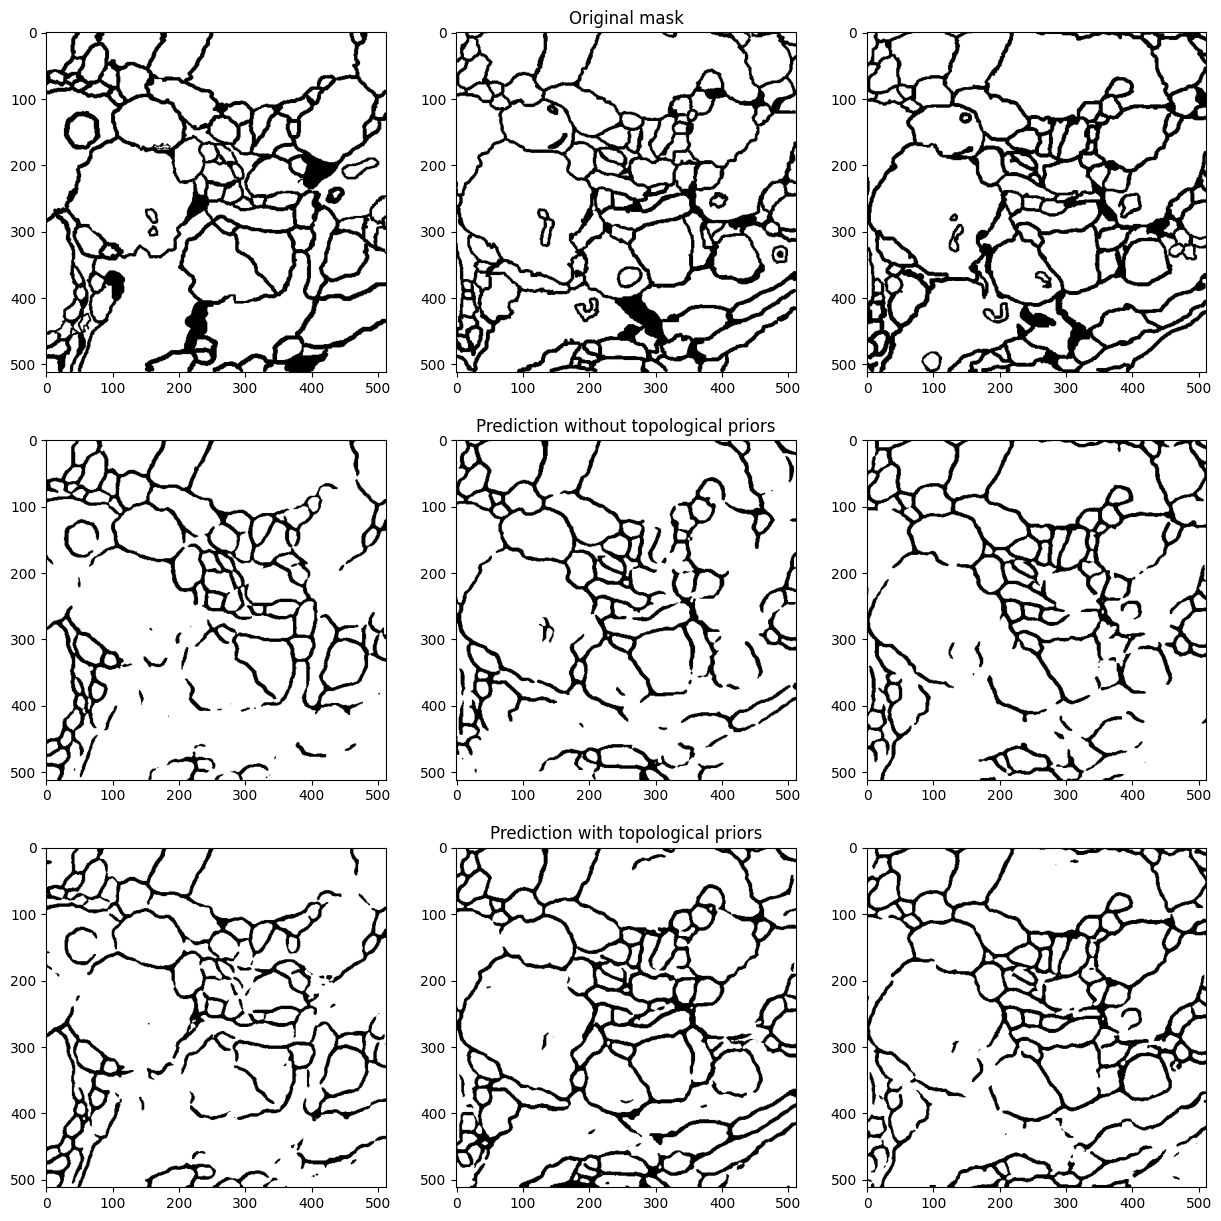

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(15,15))
ax[0,0].imshow(np.asarray(Image.open(f'results/without_topo/target_img1.png')))
ax[0,1].imshow(np.asarray(Image.open(f'results/without_topo/target_img2.png')))
ax[0,1].set_title('Original mask')
ax[0,2].imshow(np.asarray(Image.open(f'results/without_topo/target_img4.png')))
ax[1,0].imshow(np.asarray(Image.open(f'results/without_topo/pred_img1.png')))
ax[1,1].imshow(np.asarray(Image.open(f'results/without_topo/pred_img2.png')))
ax[1,1].set_title('Prediction without topological priors')
ax[1,2].imshow(np.asarray(Image.open(f'results/without_topo/pred_img4.png')))
ax[2,0].imshow(np.asarray(Image.open(f'results/topo_data/pred_img1.png')))
ax[2,1].imshow(np.asarray(Image.open(f'results/topo_data/pred_img2.png')))
ax[2,1].set_title('Prediction with topological priors')
ax[2,2].imshow(np.asarray(Image.open(f'results/topo_data/pred_img4.png')))

### Concatenation of two strategies.

We also tried to concatenate both strategies in one training, but it gives worse results.

In [ ]:
def train_topo_data(epoch_number = 5, data_path = 'CelldataVal', pretrained_path = 'model/unet-topocell_topo.pt' ):
    ############################################################
    train_dataset = TopoCellData(data_path, 'train', True, 64)
    trainloader = DataLoader(train_dataset, num_workers=4, batch_size=1, shuffle=True)
    ###############################################################
    test_dataset = CellData(data_path, 'val', True, 64)
    valloader = DataLoader(test_dataset, num_workers=4, batch_size=1, shuffle=True)
    ###############################################################
    best_loss= float('inf')
    model = UNet(dimensions=2).to(device)
    #if os.path.isfile(pretrained_path):
        #model.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cuda')))
    #optimizer = optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.98)
    optimizer = optim.Adam(model.parameters(), lr=0.00003)
    criterion = nn.CrossEntropyLoss()
    topoloss = TopLoss((64,64))
    for epoch in range(epoch_number):
        train_loss_ = []
        val_loss = []
        train_acc = []
        val_acc = []
        train_loss, val_loss = 0, 0
        # Traning Loop
        model.train()
        for inputs, target in trainloader:
            inputs, target = inputs.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            
            T = topoloss(output,target)
            L_sqdiff = criterion(output, target)
            loss = L_sqdiff + T/12000
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        model.eval()
        for input, target in valloader:
            input, target = input.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(input)
            
            T = topoloss(output,target)
            L_sqdiff = criterion(output, target)
            loss = L_sqdiff + T/12000
            val_loss += loss.item()
        if  val_loss/len(valloader) < best_loss:  # save best model
            best_loss = val_loss/len(valloader)
            torch.save(model.state_dict(), pretrained_path)
        train_loss_.append(train_loss/len(trainloader))
        if  epoch % 5 == 0:
            print(f'Epoch: {epoch} \t Train Loss: {round(train_loss/len(trainloader),3)} \t T: {round(T.item()/12000,3)} \t BCE: {round(L_sqdiff.item(),3)} \t Val Loss: {round(val_loss/len(valloader),3)}')
            diags_pred = lower_star_img(output[0,1,:,:].detach().numpy())[:-1]
            fig = plt.figure(figsize=(8,4))
            plt.suptitle("Persistent diagrams")
            
            plt.subplot(111)
            plt.title("Pred")
            plt.grid(linestyle="dotted")
            persim.plot_diagrams(diags_pred)

            plt.show()

            
    return train_loss, val_loss, train_acc, val_acc

In [ ]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
if do_train == True:
  train_loss = train_topo_data(100)
else:
  !gdown --id 1-2cMTRlYl_5ZCUEJh0vxtKeAf745ugR4
  !mv '/content/unet-topocell_topo.pt' '/content/model/'

Downloading...
From: https://drive.google.com/uc?id=1-2cMTRlYl_5ZCUEJh0vxtKeAf745ugR4
To: /content/unet-topocell_topo.pt
124MB [00:01, 101MB/s]


Epoch: 0 	 Train Loss: 0.965 	 T: 0.414 	 BCE: 0.668 	 Val Loss: 1.081


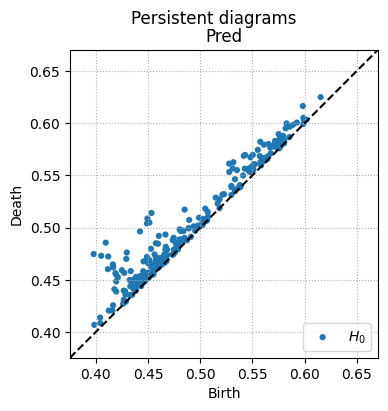

Epoch: 5 	 Train Loss: 0.792 	 T: 0.138 	 BCE: 0.54 	 Val Loss: 0.709


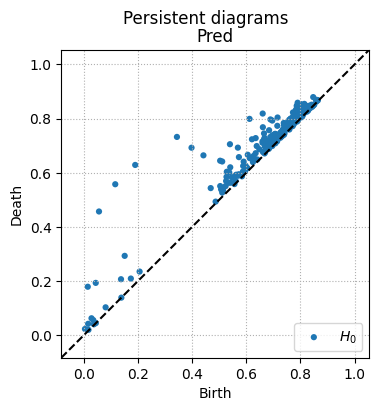

Epoch: 10 	 Train Loss: 0.71 	 T: 0.088 	 BCE: 0.53 	 Val Loss: 0.64


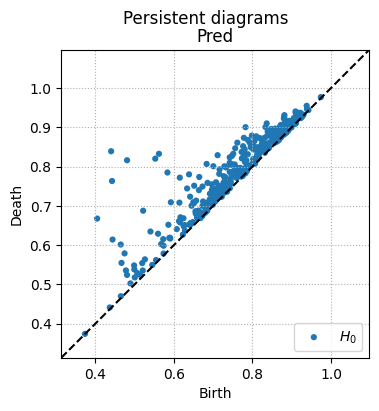

Epoch: 15 	 Train Loss: 0.68 	 T: 0.093 	 BCE: 0.465 	 Val Loss: 0.633


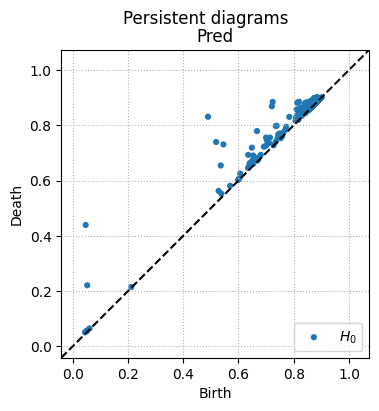

Epoch: 20 	 Train Loss: 0.668 	 T: 0.064 	 BCE: 0.462 	 Val Loss: 0.598


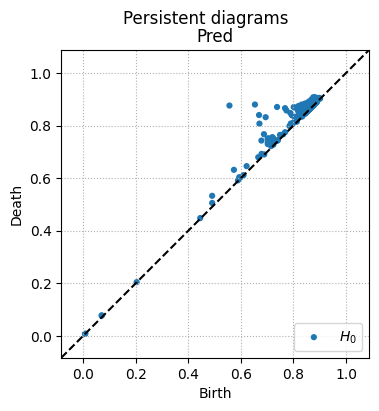

Epoch: 25 	 Train Loss: 0.662 	 T: 0.065 	 BCE: 0.465 	 Val Loss: 0.639


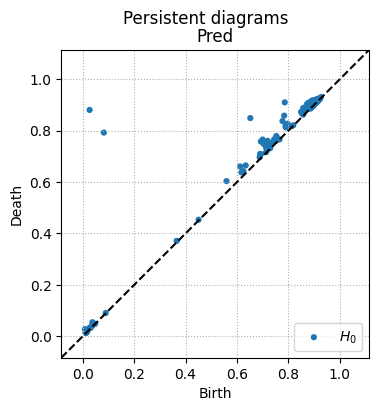

Epoch: 30 	 Train Loss: 0.621 	 T: 0.053 	 BCE: 0.44 	 Val Loss: 0.588


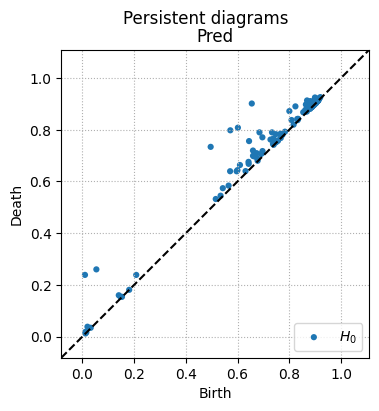

Epoch: 35 	 Train Loss: 0.597 	 T: 0.083 	 BCE: 0.473 	 Val Loss: 0.534


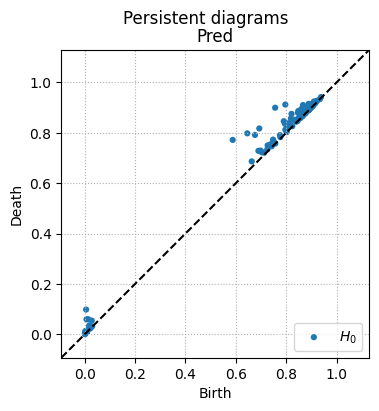

Epoch: 40 	 Train Loss: 0.603 	 T: 0.04 	 BCE: 0.407 	 Val Loss: 0.509


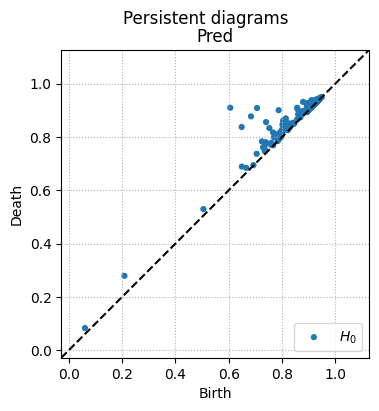

Epoch: 45 	 Train Loss: 0.61 	 T: 0.065 	 BCE: 0.468 	 Val Loss: 0.568


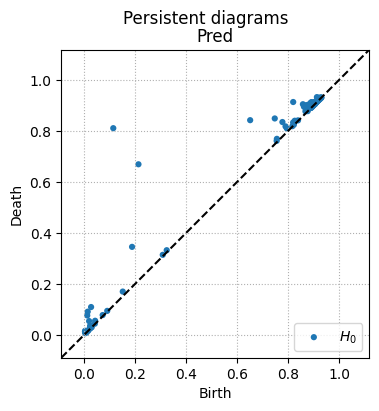

Epoch: 50 	 Train Loss: 0.629 	 T: 0.125 	 BCE: 0.456 	 Val Loss: 0.498


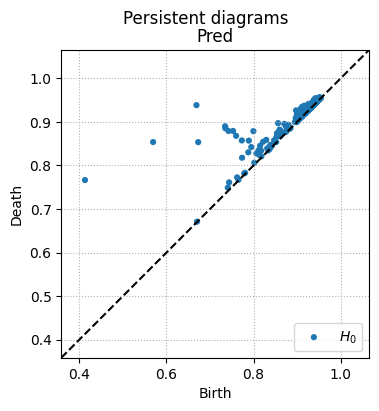

Epoch: 55 	 Train Loss: 0.583 	 T: 0.031 	 BCE: 0.396 	 Val Loss: 0.515


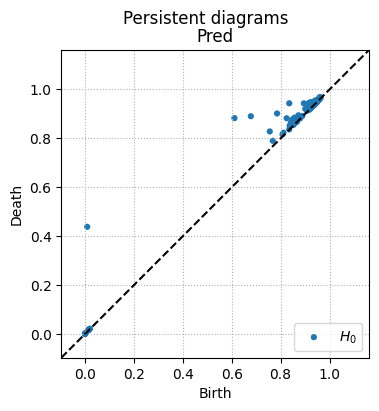

Epoch: 60 	 Train Loss: 0.594 	 T: 0.028 	 BCE: 0.394 	 Val Loss: 0.53


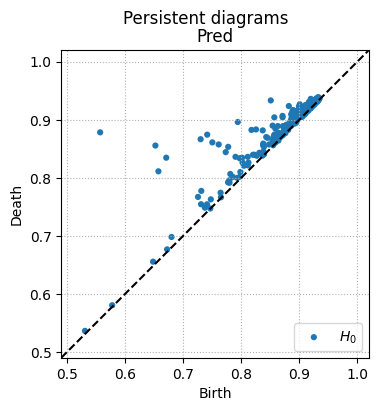

Epoch: 65 	 Train Loss: 0.633 	 T: 0.028 	 BCE: 0.391 	 Val Loss: 0.468


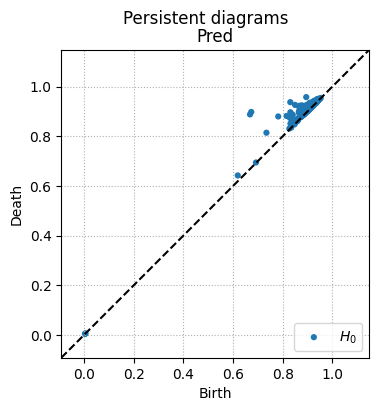

Epoch: 70 	 Train Loss: 0.546 	 T: 0.047 	 BCE: 0.42 	 Val Loss: 0.463


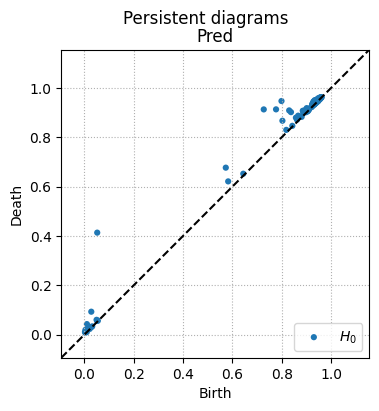

Epoch: 75 	 Train Loss: 0.549 	 T: 0.044 	 BCE: 0.406 	 Val Loss: 0.481


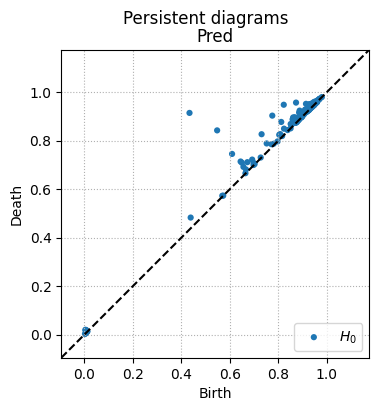

Epoch: 80 	 Train Loss: 0.582 	 T: 0.03 	 BCE: 0.383 	 Val Loss: 0.525


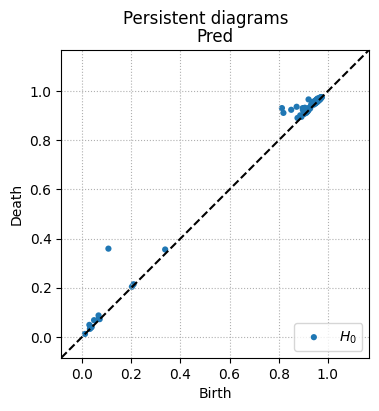

Epoch: 85 	 Train Loss: 0.588 	 T: 0.099 	 BCE: 0.434 	 Val Loss: 0.465


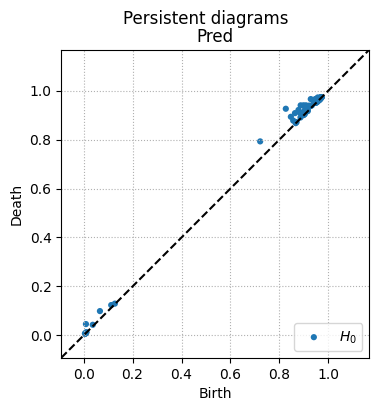

Epoch: 90 	 Train Loss: 0.544 	 T: 0.045 	 BCE: 0.44 	 Val Loss: 0.488


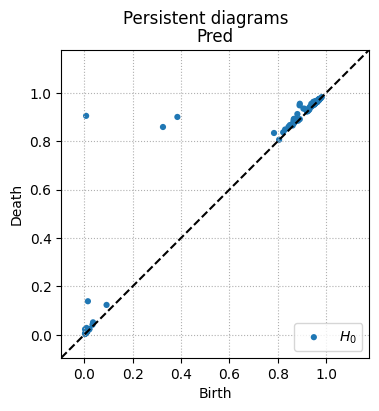

Epoch: 95 	 Train Loss: 0.574 	 T: 0.107 	 BCE: 0.502 	 Val Loss: 0.477


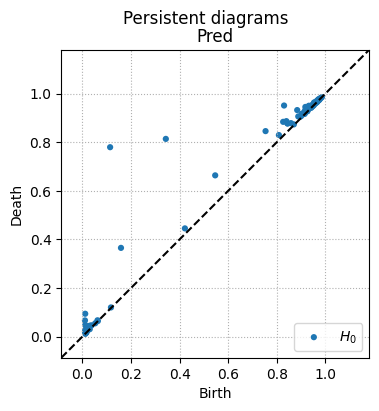

(14.199852257966995, 2.587684452533722, [], [])

In [ ]:
#random.seed(1)
#np.random.seed(1)
#torch.manual_seed(1)
#train_loss = train_topo_data(100)

In [ ]:
!mkdir results/topo_data_topo

In [ ]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

ac_td, cp_td, cr_td, ql_td, d_td,b_td = predict(pretrained_path = 'model/unet-topocell_topo.pt',model_type = 'topo_data_topo')
ac_td,cp_td,cr_td,ql_td,d_td,b_td

(0.9052322387695313,
 0.9524833599620741,
 0.9310766356513298,
 0.8895263994683266,
 0.9415069858064282,
 1.7)

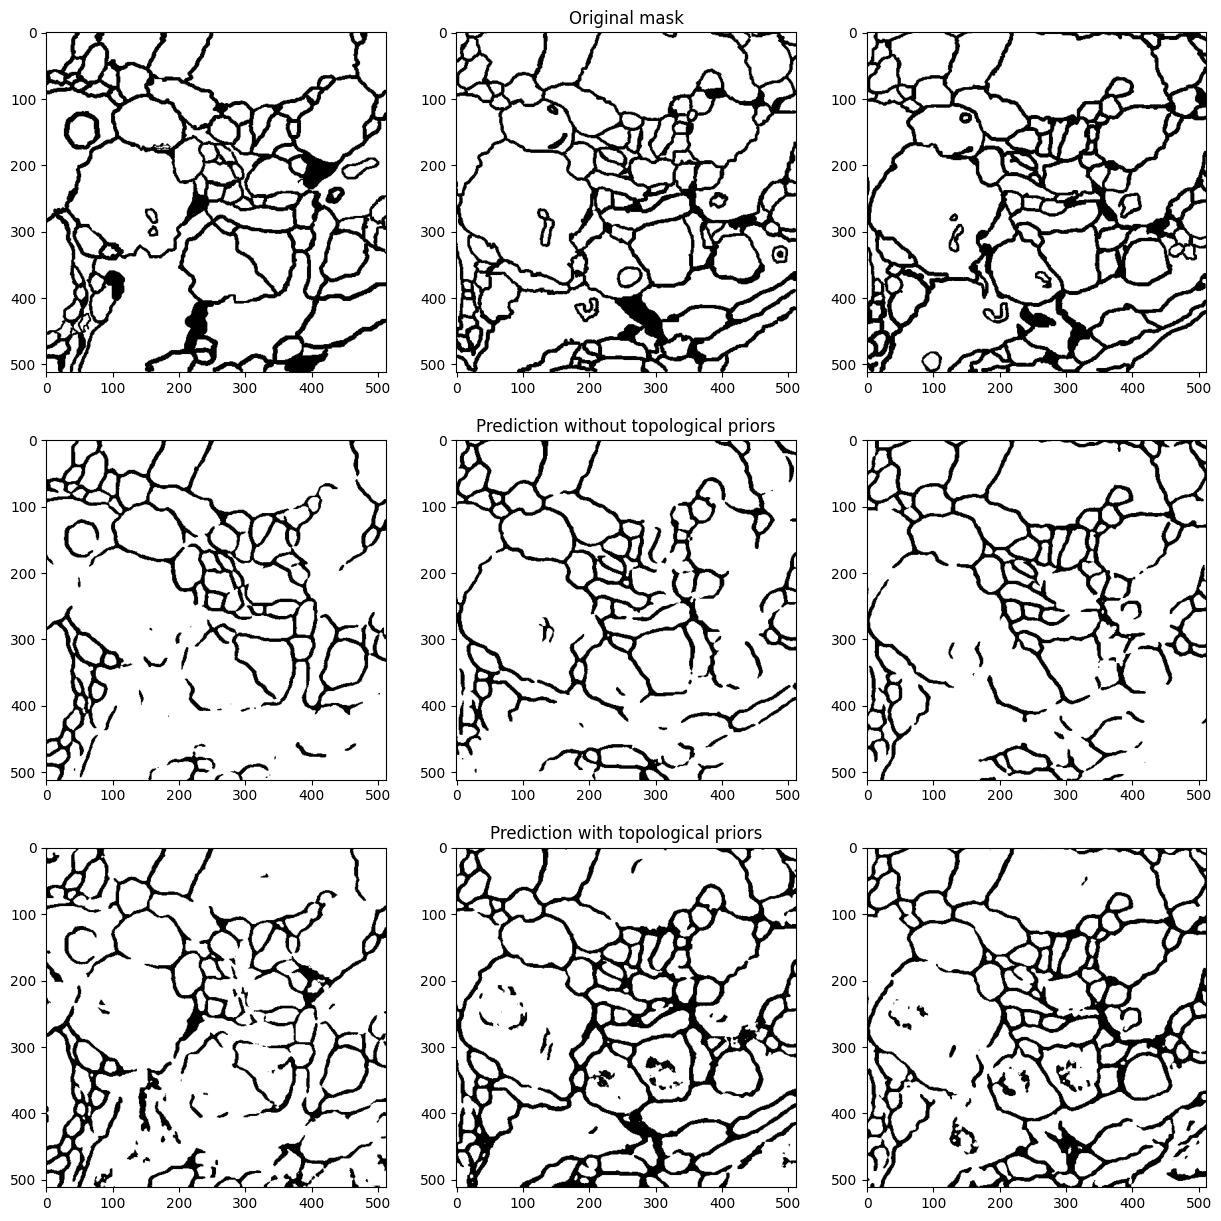

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(15,15))
ax[0,0].imshow(np.asarray(Image.open(f'results/without_topo/target_img1.png')))
ax[0,1].imshow(np.asarray(Image.open(f'results/without_topo/target_img2.png')))
ax[0,1].set_title('Original mask')
ax[0,2].imshow(np.asarray(Image.open(f'results/without_topo/target_img4.png')))
ax[1,0].imshow(np.asarray(Image.open(f'results/without_topo/pred_img1.png')))
ax[1,1].imshow(np.asarray(Image.open(f'results/without_topo/pred_img2.png')))
ax[1,1].set_title('Prediction without topological priors')
ax[1,2].imshow(np.asarray(Image.open(f'results/without_topo/pred_img4.png')))
ax[2,0].imshow(np.asarray(Image.open(f'results/topo_data_topo/pred_img1.png')))
ax[2,1].imshow(np.asarray(Image.open(f'results/topo_data_topo/pred_img2.png')))
ax[2,1].set_title('Prediction with topological priors')
ax[2,2].imshow(np.asarray(Image.open(f'results/topo_data_topo/pred_img4.png')))

# Extra
### Example for Topological Input image processing for getting clear intuition

Here, we will take a simple example from paper, this is unsupervised segmentation on simple geometric sample image

This example will give us  more intuition of topological input image processing 

In [ ]:
!gdown --id 1iFcP9BYv52xVdtRxTfbhxxzTY2gR8oNu
!gdown --id 1GQ_tr35QyoQ_QtRBxUPpLJKyO0ySHjlN

Downloading...
From: https://drive.google.com/uc?id=1iFcP9BYv52xVdtRxTfbhxxzTY2gR8oNu
To: /content/input.jpg
100% 114k/114k [00:00<00:00, 3.67MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GQ_tr35QyoQ_QtRBxUPpLJKyO0ySHjlN
To: /content/groundtruth.png
100% 6.62k/6.62k [00:00<00:00, 5.82MB/s]


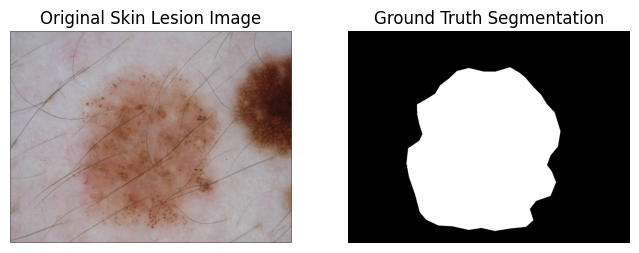

In [ ]:
img = mpimg.imread("input.jpg")
sgm_truth = mpimg.imread("groundtruth.png")

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.flatten()

ax[0].imshow(img)
ax[0].set_axis_off()
ax[0].set_title("Original Skin Lesion Image", fontsize=12)

ax[1].imshow(sgm_truth, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("Ground Truth Segmentation", fontsize=12)

plt.show()

In [ ]:
img_gray = np.asarray(PIL.Image.fromarray((img).astype(np.uint8)).convert("L")).copy().astype("float") # grayscale
img_gray += 0.01 * np.random.randn(*img_gray.shape) # random noise
TIP_img = topological_process_img(img_gray, window_size=25, border_width=25)

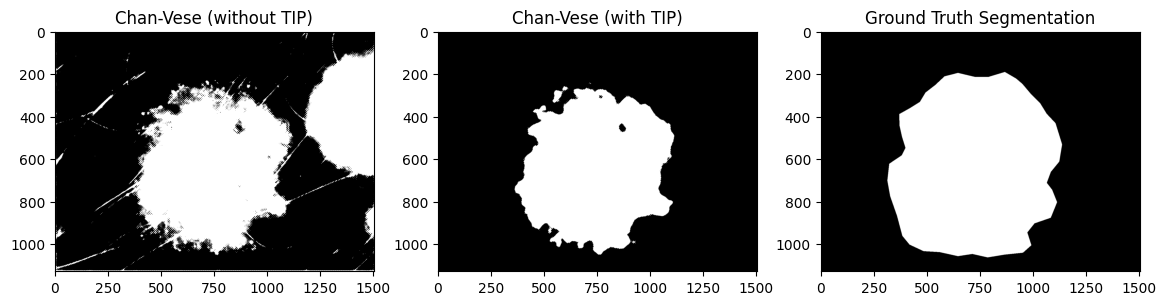

In [ ]:
# We conduct the Chan-Vese segmentation algorithm using the standard settings
from skimage.segmentation import chan_vese # chan_vese segmentation
sgm_without_TIP = chan_vese(img_gray)
sgm_with_TIP = chan_vese(TIP_img["processed"])

# We plot the different segmentations
plt.figure(figsize=(14, 8))
plt.subplot(1,3,1)
plt.imshow(sgm_without_TIP, cmap="gray")
plt.title("Chan-Vese (without TIP)", fontsize=12)

plt.subplot(1,3,2)
plt.imshow(sgm_with_TIP, cmap="gray")
plt.title("Chan-Vese (with TIP)", fontsize=12)

plt.subplot(1,3,3)
plt.imshow(sgm_truth, cmap="gray")

plt.title("Ground Truth Segmentation", fontsize=12)

plt.show()

Hence, TIP: Topological Image Processing of input image performs well, then without processing for Unsupervised segmentation (already developed in skimage toolbox)